# <font color=green>**Participez à la conception d'une voiture autonome**
## Notebook 2 - Test trois modèles FCN,U-Net et PSPNet

Nous avons utilisé l'API Keras, qui est intégrée au backend Tensorflow, pour construire et évaluer nos modèles 

In [1]:
#!pip install -q -U tensorflow-addons

In [2]:
#!pip install segmentation-models

In [1]:
#import librairies
from collections import namedtuple
import random
import numpy as np
import pandas as pd
import os.path
import scipy.misc
import os
from glob import glob
from sklearn.utils import shuffle
import random
import time
import shutil
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
#import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model, Sequential
%env SM_FRAMEWORK=tf.keras
from segmentation_models.metrics import IOUScore,FScore
from warnings import warn
from functions import *
from CustomDataGenerator import *

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [2]:
# Set variables
#patch for acces to train, valid and test data
DATA_PATH = "../data" 
IMAGE_SIZE = 128
EPOCHS = 3
f1_score = FScore()
iou_score =  IOUScore()
metrics = ['categorical_accuracy',f1_score,iou_score]
metrics_to_display = ["loss","categorical_accuracy","f1-score","iou_score"]
optimizer='adam'
tab_compare = pd.DataFrame(columns=['Model','Data augmentation','Categorical accuracy','Loss','Dice Coefficient','Intersection-Over-Union','Build training time','Used memory','Predict data time'])

In [3]:
# Check whether GPU is enabled
if not tf.test.gpu_device_name():
    warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


Recuperation des labels

In [4]:
# get labels
labels = get_label_info()
label_values, colors_replacements = get_labels_mapping(labels)

Recuperation des données

In [5]:
#train data
train_batch = glob(os.path.join(DATA_PATH+'/train/images/', '*.png'))
train_label_batch = glob(os.path.join(DATA_PATH +'/train/masks/', '*.png'))
train_batch.sort()
train_label_batch.sort()
#validation data
val_batch = glob(os.path.join(DATA_PATH+'/val/images/', '*.png'))
val_label_batch = glob(os.path.join(DATA_PATH +'/val/masks/', '*.png'))
val_batch.sort()
val_label_batch.sort()
#test data
test_batch = glob(os.path.join(DATA_PATH+'/test/images/', '*.png'))
test_label_batch = glob(os.path.join(DATA_PATH +'/test/masks/', '*.png'))
test_batch.sort()
test_label_batch.sort()

In [6]:
# pair of path data for image, mask
train_set = get_tuple_image_mask(train_batch,train_label_batch)[:100]
valid_set = get_tuple_image_mask(val_batch,val_label_batch)[:30]
test_set = get_tuple_image_mask(test_batch,test_label_batch)[:10]
print(train_batch[0])
print(train_label_batch[0])


../data/train/images/aachen_000000_000019.png
../data/train/masks/aachen_000000_000019.png


Test sur une image

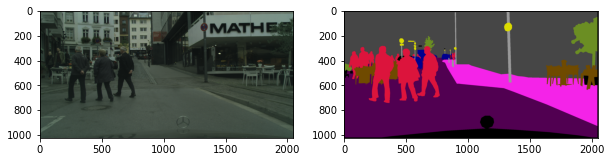

In [7]:
temp = train_set[20]
img = img_to_array(load_img(temp[0]))
mask = img_to_array(load_img(temp[1]))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

## Generateur des données

In [8]:
#generation des données
train_generator = CustomDataGenerator(images_and_labels=train_set, label_values=label_values,target_size=(IMAGE_SIZE,2*IMAGE_SIZE), colors_replacements=colors_replacements,data_augmentation=False)
val_generator = CustomDataGenerator(images_and_labels=valid_set, label_values=label_values, target_size=(IMAGE_SIZE,2*IMAGE_SIZE),colors_replacements=colors_replacements)
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()
print('train_steps :',train_steps,'   val_steps :',val_steps)

train_steps : 10    val_steps : 3


In [9]:
X,y = train_generator.__getitem__(1)
X.shape,y.shape

((10, 128, 256, 3), (10, 128, 256, 8))

In [10]:
X_val,y_val = train_generator.__getitem__(1)
X_val.shape,y_val.shape

((10, 128, 256, 3), (10, 128, 256, 8))

## 1. FCN - Modèle de reference

In [11]:
#Fully Convolutional Networks 
model_FCN =FCN_model(input_height =IMAGE_SIZE,input_width = 2*IMAGE_SIZE)
model_FCN.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=metrics)
model_FCN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_0 (Conv2D)               (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_1 (Conv2D)               (None, 128, 256, 64) 36928       block1_0[0][0]                   
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 64, 128, 64)  0           block1_1[0][0]                   
______________________________________________________________________________________________

In [12]:
# fit of FCN model
start = time.time()
results_FCN = model_FCN.fit(train_generator , steps_per_epoch=train_steps ,epochs=EPOCHS,validation_data=val_generator,validation_steps=val_steps)
end = time.time()
builf_FCN_time =timer(start,end)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (o

In [13]:
scores = model_FCN.evaluate(X_val,y_val, verbose=2)

1/1 - 0s - loss: 1.1391 - categorical_accuracy: 0.6789 - f1-score: 0.2316 - iou_score: 0.1497


MODEL:  FCN
Build training model time:  00:02:09.59
Predict test data time:  00:00:11.82
3/3 [==============================] - 8s 3s/step - loss: 1.1732 - categorical_accuracy: 0.5891 - f1-score: 0.2642 - iou_score: 0.17
Categorical accuracy: 58.9099
Loss : 1.1732
Dice Coefficient : 26.4199
Intersection-Over-Union : 17.7438


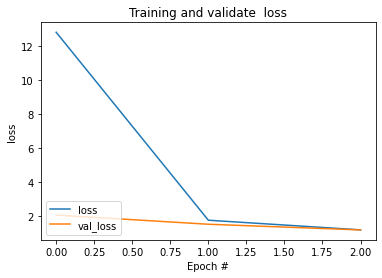

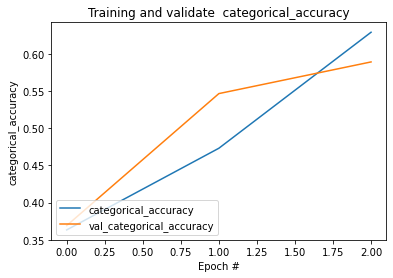

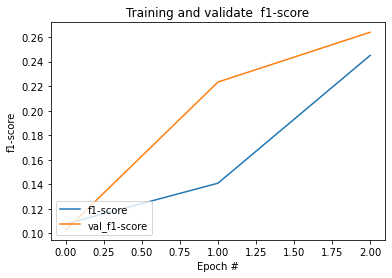

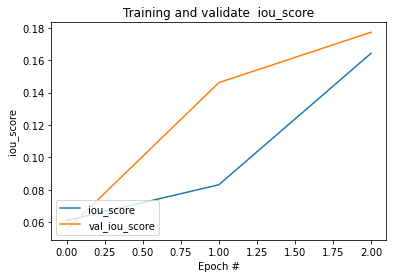

In [14]:
tab_compare=tab_compare.append(get_scoring(model_FCN,'FCN', val_generator,builf_FCN_time),ignore_index=True)
display_loss_and_metrics(EPOCHS,results_FCN.history,metrics_to_display)

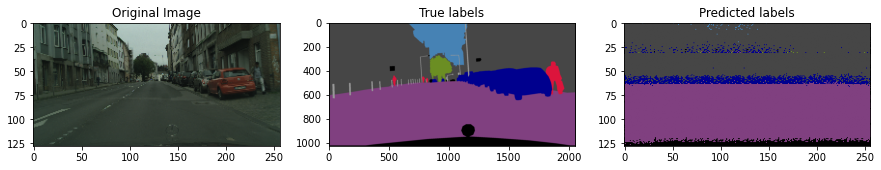

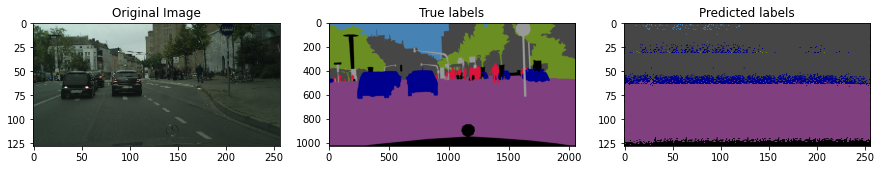

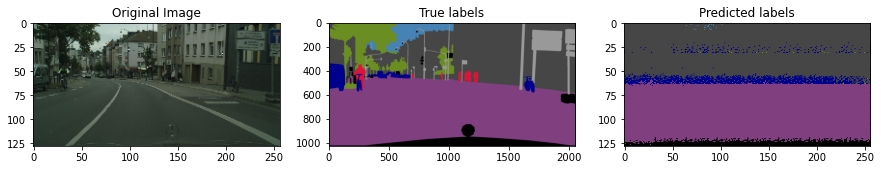

In [15]:
display_random_test_images(model_FCN,train_set,label_values,colors_replacements,nb_images=3,image_size =IMAGE_SIZE)

## 2. U-Net

In [16]:
# create Unet model
model_Unet = Unet(IMAGE_SIZE,2*IMAGE_SIZE, 64)
model_Unet.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 256, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 256, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 256, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [17]:
model_Unet.compile(optimizer=optimizer, loss='categorical_crossentropy' ,metrics=metrics)

In [18]:
train_generator = CustomDataGenerator(images_and_labels=train_set,batch_size = 6, label_values=label_values,target_size=(IMAGE_SIZE,2*IMAGE_SIZE), colors_replacements=colors_replacements,data_augmentation=True)
val_generator = CustomDataGenerator(images_and_labels=valid_set,batch_size = 6, label_values=label_values, target_size=(IMAGE_SIZE,2*IMAGE_SIZE),colors_replacements=colors_replacements)
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()
train_steps, val_steps

(16, 5)

In [19]:
X_val,y_val = train_generator.__getitem__(1)
X_val.shape,y_val.shape
#X[0]

((6, 128, 256, 3), (6, 128, 256, 8))

In [20]:
start = time.time()
results_Unet = model_Unet.fit(train_generator , steps_per_epoch=train_steps ,epochs=EPOCHS,validation_data=val_generator,validation_steps=val_steps)
end = time.time()
builf_Unet_time =timer(start,end)

Epoch 1/3
16/16 [==============================] - 46s 2s/step - loss: 1.8031 - categorical_accuracy: 0.4008 - f1-score: 0.1782 - iou_score: 0.1104 - val_loss: 2940.8984 - val_categorical_accuracy: 0.1629 - val_f1-score: 0.0352 - val_iou_score: 0.020
Epoch 2/3
16/16 [==============================] - 38s 2s/step - loss: 0.8910 - categorical_accuracy: 0.7125 - f1-score: 0.3627 - iou_score: 0.2590 - val_loss: 3070.6865 - val_categorical_accuracy: 0.1802 - val_f1-score: 0.0493 - val_iou_score: 0.028
Epoch 3/3
16/16 [==============================] - 38s 2s/step - loss: 0.7678 - categorical_accuracy: 0.7592 - f1-score: 0.4224 - iou_score: 0.3078 - val_loss: 408.0809 - val_categorical_accuracy: 0.2347 - val_f1-score: 0.0779 - val_iou_score: 0.04


MODEL:  U-Net
Build training model time:  00:02:03.24
Predict test data time:  00:00:11.13
5/5 [==============================] - 8s 2s/step - loss: 408.0809 - categorical_accuracy: 0.2347 - f1-score: 0.0775 - iou_score: 0.04
Categorical accuracy: 23.4727
Loss : 408.0809
Dice Coefficient : 7.7507
Intersection-Over-Union : 4.5200


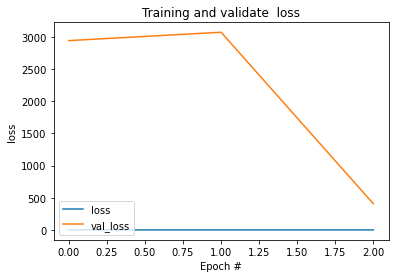

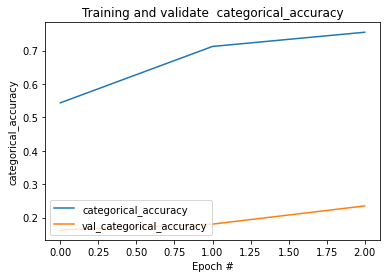

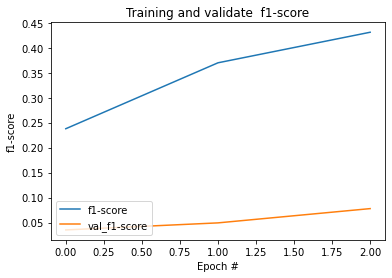

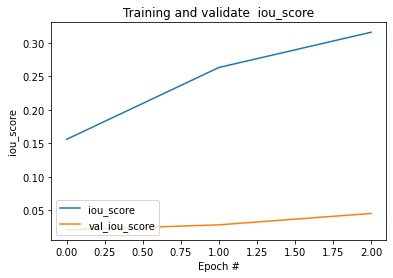

In [21]:
tab_compare=tab_compare.append(get_scoring(model_Unet,'U-Net', val_generator,builf_Unet_time),ignore_index=True)
display_loss_and_metrics(EPOCHS,results_Unet.history,metrics_to_display)

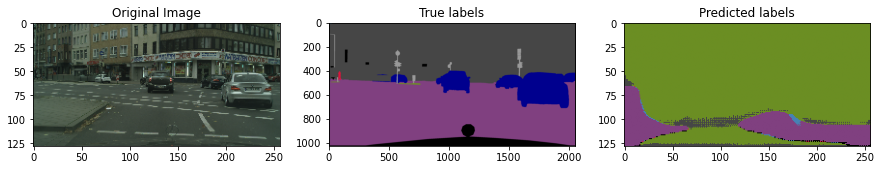

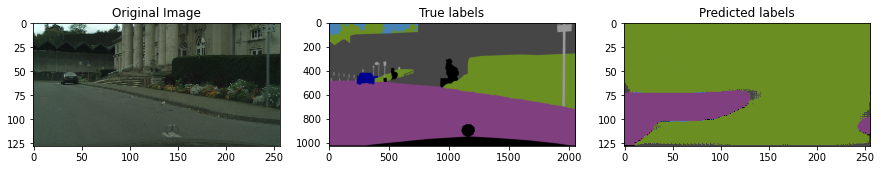

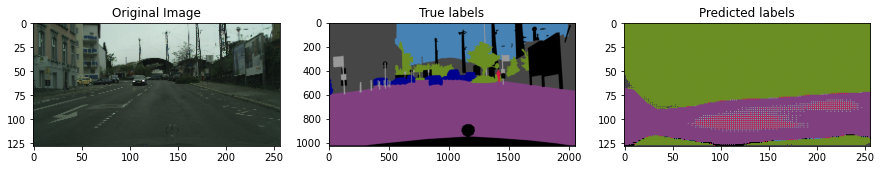

In [22]:
display_random_test_images(model_Unet,train_set,label_values,colors_replacements,nb_images=3,image_size =IMAGE_SIZE)

## 3.PSPNet

In [23]:
import segmentation_models as sm
IMAGE_SIZE = 192
model_PSPNet = sm.PSPNet( classes=8, activation='sigmoid',input_shape=((IMAGE_SIZE,2*IMAGE_SIZE, 3)))
model_PSPNet.compile(optimizer=optimizer, loss='categorical_crossentropy' ,metrics=metrics)

In [24]:
train_generator = CustomDataGenerator(images_and_labels=train_set,batch_size = 6, label_values=label_values,target_size=(IMAGE_SIZE,2*IMAGE_SIZE), colors_replacements=colors_replacements,data_augmentation=False)
val_generator = CustomDataGenerator(images_and_labels=valid_set,batch_size = 6, label_values=label_values, target_size=(IMAGE_SIZE,2*IMAGE_SIZE),colors_replacements=colors_replacements)
train_steps = train_generator.__len__()
val_steps = val_generator.__len__()
train_steps, val_steps

(16, 5)

In [25]:
X_val,y_val = train_generator.__getitem__(1)
X_val.shape,y_val.shape

((6, 192, 384, 3), (6, 192, 384, 8))

In [26]:
start = time.time()
results_PSPNet = model_PSPNet.fit(train_generator , steps_per_epoch=train_steps ,epochs=EPOCHS,validation_data=val_generator,validation_steps=val_steps)
end = time.time()
builf_PSP_time =timer(start,end)

Epoch 1/3
16/16 [==============================] - 47s 3s/step - loss: 1.5143 - categorical_accuracy: 0.4890 - f1-score: 0.2263 - iou_score: 0.1451 - val_loss: 54.2005 - val_categorical_accuracy: 0.0981 - val_f1-score: 0.0753 - val_iou_score: 0.041
Epoch 2/3
16/16 [==============================] - 42s 3s/step - loss: 0.8360 - categorical_accuracy: 0.7031 - f1-score: 0.3007 - iou_score: 0.2052 - val_loss: 7.7109 - val_categorical_accuracy: 0.2451 - val_f1-score: 0.1953 - val_iou_score: 0.11
Epoch 3/3
16/16 [==============================] - 42s 3s/step - loss: 0.6837 - categorical_accuracy: 0.7748 - f1-score: 0.3456 - iou_score: 0.2413 - val_loss: 9.1016 - val_categorical_accuracy: 0.5534 - val_f1-score: 0.1515 - val_iou_score: 0.09


MODEL:  PSPNet
Build training model time:  00:02:12.54
Predict test data time:  00:00:11.64
5/5 [==============================] - 10s 2s/step - loss: 9.1016 - categorical_accuracy: 0.5534 - f1-score: 0.1516 - iou_score: 0.097
Categorical accuracy: 55.3378
Loss : 9.1016
Dice Coefficient : 15.1584
Intersection-Over-Union : 9.7007


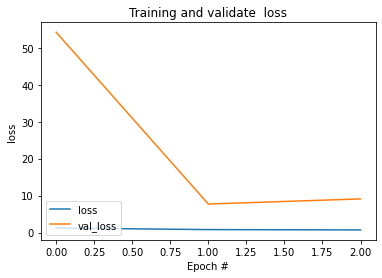

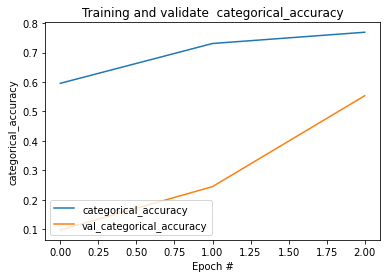

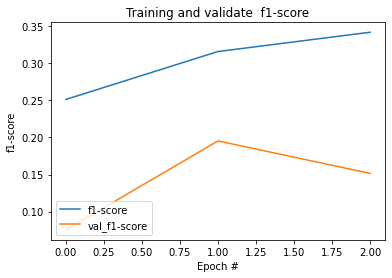

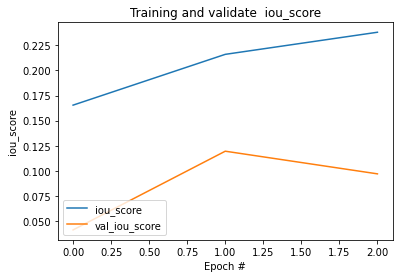

In [27]:
tab_compare=tab_compare.append(get_scoring(model_PSPNet,'PSPNet', val_generator,builf_PSP_time),ignore_index=True)
display_loss_and_metrics(EPOCHS,results_PSPNet.history,metrics_to_display)

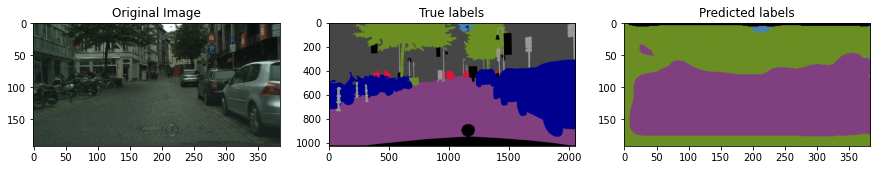

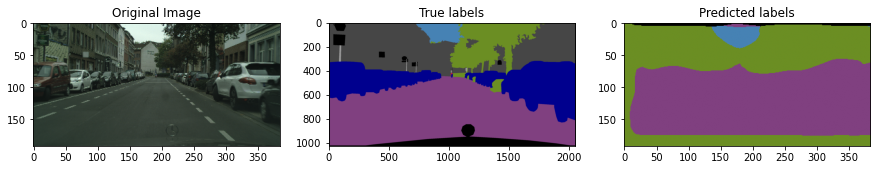

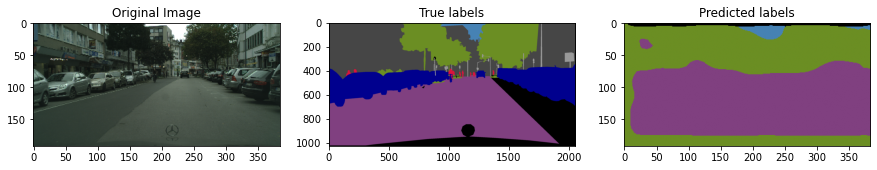

In [28]:
display_random_test_images(model_PSPNet,train_set,label_values,colors_replacements,nb_images=3,image_size =IMAGE_SIZE)

In [29]:
tab_compare.head()

,Model,Data augmentation,Categorical accuracy,Loss,Dice Coefficient,Intersection-Over-Union,Build training time,Used memory,Predict data time
0,FCN,No,58.909911,1.173239,26.419893,17.743783,00:02:09.59,0,00:00:11.82
1,U-Net,No,23.472697,408.080933,7.750664,4.520039,00:02:03.24,0,00:00:11.13
2,PSPNet,No,55.337816,9.101552,15.158364,9.700700,00:02:12.54,0,00:00:11.64


U-Net montre de très bonnes performances parmi les trois modèle testés sur plus de 2000 images sur 8 epoches.
